In [3]:
pip install python-igraph


     |████████████████████████████████| 3.2 MB 26.2 MB/s 


In [4]:
pip install plfit

     |████████████████████████████████| 193 kB 38.0 MB/s 
  Created wheel for plfit: filename=plfit-1.0.3-cp37-cp37m-linux_x86_64.whl size=123181 sha256=22eeea9a0ec678a91c874a0c7a0add474bc7d8f7a5818cb9be5cda22528cd1b3
  Stored in directory: /root/.cache/pip/wheels/44/c5/30/2761386f6aea1d7ca4ffb706f90535faa81365be034b32055a
Successfully built plfit


In [5]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plfit

from statistics import mode

## Question 1:

In [ ]:
##Below code was taken from our lab

In [312]:
## read edges and build weighted directed graph
D = pd.read_csv("connections.csv")
g = ig.Graph.TupleList([tuple(x) for x in D.values], directed=True, edge_attrs=['weight'])
D.head() 

,orig_airport,dest_airport,total_passengers
0,SFO,LAX,1442105
1,LAX,SFO,1438639
2,MCO,ATL,1436625
3,ATL,MCO,1424069
4,LAX,JFK,1277731


In [313]:
## read vertex attributes and add to graph
A = pd.read_csv('airports_loc.csv')
lookup = {k:v for v,k in enumerate(A['airport'])}
l = [lookup[x] for x in g.vs()['name']]
g.vs()['layout'] = [(A['lon'][i],A['lat'][i]) for i in l]
g.vs()['state'] = [A['state'][i] for i in l]
g.vs()['city'] = [A['city'][i] for i in l]
A.head() ## first few rows in A

,airport,lon,lat,state,city
0,ABE,-75.440804,40.652100,PA,Allentown
1,ABI,-99.681900,32.411301,TX,Abilene
2,ABQ,-106.609001,35.040199,NM,Albuquerque
3,ABR,-98.421799,45.449100,SD,Aberdeen
4,ABY,-84.194504,31.535500,GA,Albany


In [314]:
## Build smaller subgraph 'G' for New York
G = g.subgraph([v for v in g.vs() if v['state'] == 'NY'])

## drop isolated vertices (i.e. without in-state connections)
G = G.subgraph([v for v in G.vs() if v.degree()>0])

## remove loops if any
G = G.simplify(multiple=False)
print(G.vcount(),'nodes and',G.ecount(),'directed edges')


13 nodes and 50 directed edges


In [315]:
## compute normalized weights 
mw = np.max(G.es['weight'])
G.es()['normalized_weight'] = [w/mw for w in G.es()['weight']]

## directed degree centrality
def degree_centrality(g, weights=None):
    n = g.vcount()
    if g.is_directed():
        dc = [sum(x)/(2*(n-1)) for x in zip(g.strength(mode='in',weights=weights),\
              g.strength(mode='out',weights=weights))]
    else:
        dc = [x/(n-1) for x in g.strength(weights=weights)]
    return dc

In [316]:
## compute several centrality measures for the CA subgraph G
C = pd.DataFrame({'airport':G.vs()['name'],\
                  'degree':degree_centrality(G,weights='normalized_weight'),\
                  'pagerank':G.pagerank(weights='weight'),'authority':G.authority_score(weights='weight'),\
                  'hub':G.hub_score(weights='weight'),'between':G.betweenness(),\
                  'closeness':G.closeness()})

## normalize betweenness
n = G.vcount()
C['between'] = [2*x/((n-1)*(n-2)) for x in C['between']]

## sort w.r.t. degree centrality, look at top airports
Cs = C.sort_values(by='degree', ascending=False)
Cs.head()


,airport,degree,pagerank,authority,hub,between,closeness
0,JFK,0.173125,0.342720,1.000000,0.373760,0.647727,0.705882
2,BUF,0.101629,0.195702,0.261299,1.000000,0.167929,0.705882
4,ROC,0.054908,0.109433,0.141841,0.546989,0.000000,0.631579
5,SYR,0.044959,0.097118,0.113975,0.459400,0.243687,0.750000
1,LGA,0.040011,0.108312,0.213367,0.078989,0.286616,0.750000


In [317]:
## bottom ones
Cs.tail()


,airport,degree,pagerank,authority,hub,between,closeness
10,JRB,0.000132,0.011636,0.000171,0.002371,0.000000,0.428571
11,ART,0.000126,0.012122,0.000108,0.000028,0.000000,0.444444
12,OGS,0.000120,0.012027,0.000091,0.000032,0.000000,0.444444
6,ELM,0.000030,0.011592,0.000039,0.000020,0.045455,0.571429
7,BGM,0.000021,0.013010,0.000139,0.000037,0.005051,0.500000


## **Question 2:**

In [6]:
## fast Chung-Lu: generate m edges w.r.t. distribution d
def fastCL(d, m):
    n = len(d)
    s = np.sum(d)
    p = [i/s for i in d]
    target = m
    tples = []
    ## generate edges (tuples), drop collisions, until m edges are obtained.
    while len(tples) < target:
        s = target - len(tples)
        e0 = np.random.choice(n, size=s, replace=True, p=p)
        e1 = np.random.choice(n, size=s, replace=True, p=p)
        tples.extend([(min(e0[i],e1[i]),max(e0[i],e1[i])) for i in range(len(e0)) if e0[i]!=e1[i]]) ## ignore loops
        tples = list(set(tples)) ## drop collisions
    return tples

In [18]:
## power law graph
gamma = 2.5
n = 10000

## min and max degrees
delta = 1
Delta = np.sqrt(n)

## generate degrees
W = []
for i in np.arange(1,n+1):
    W.append(delta * (n/(i-1+n/(Delta/delta)**(gamma-1)))**(1/(gamma-1)))

# deg = [int(np.round(w)) for w in W] ## to enforce integer weights, not an obligation
deg = W

## generate graph with Chung-Lu model
m = int(np.mean(deg)*n/2)
tpl = fastCL(deg,m)
g1 = ig.Graph.TupleList(tpl)


In [44]:
## compute normalized weights 
g1.es['weight']=1 ## assuming weights as 1 for each edge
mw = np.max(g1.es['weight'])
g1.es()['normalized_weight'] = [w/mw for w in g1.es()['weight']]


In [45]:
def degree_centrality(g, w=None):
    n = g.vcount()
    if g.is_directed():
        dc = [sum(x)/(2*(n-1)) for x in zip(g.strength(mode='in',weights=w),\
              g.strength(mode='out',weights=w))]
    else:
        dc = [x/(n-1) for x in g.strength(weights=w)]
    return dc

In [53]:
## Creating a database for all centrality measures
C = pd.DataFrame({'degree':degree_centrality(g1,w=None),'pagerank':g1.pagerank(),\
                  'authority':g1.authority_score(),\
                  'hub':g1.hub_score(),\
                  'between':g1.betweenness(),\
                  'closeness':g1.closeness(),'k':g1.degree()})
C = C.groupby(by='k').mean()



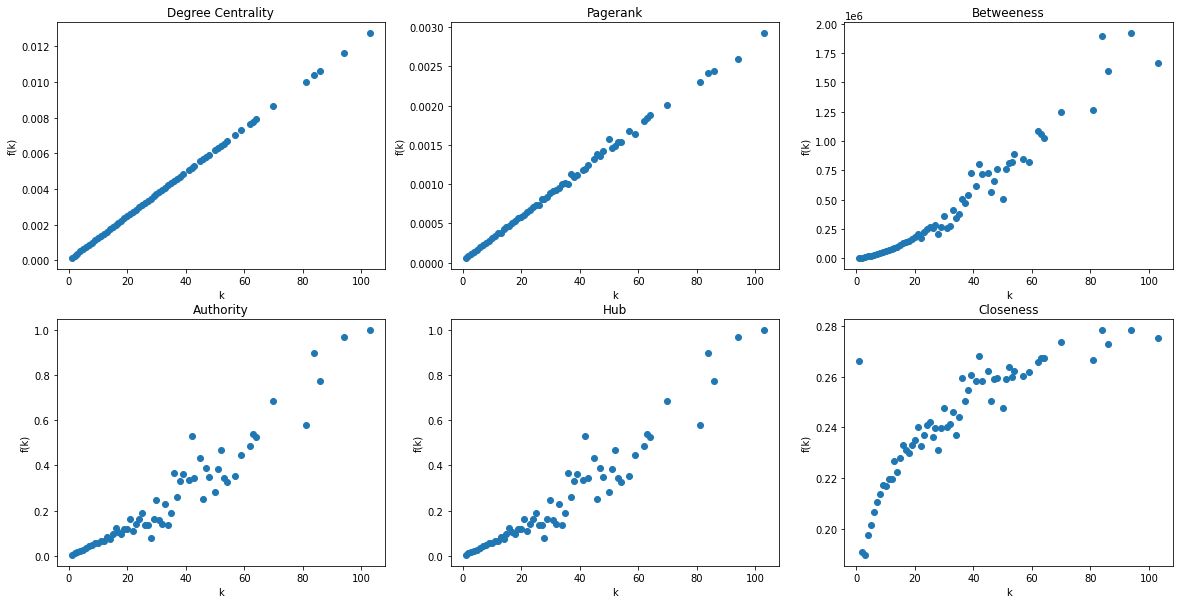

In [55]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))
ax[0, 0].scatter(C.index, C.degree)
ax[0, 0].set_title('Degree Centrality')

ax[0, 1].scatter(C.index, C.pagerank)
ax[0, 1].set_title('Pagerank')

ax[1, 0].scatter(C.index, C.authority)
ax[1, 0].set_title('Authority')

ax[1, 1].scatter(C.index, C.hub)
ax[1, 1].set_title('Hub')

ax[0, 2].scatter(C.index, C.between)
ax[0, 2].set_title('Betweeness')

ax[1, 2].scatter(C.index, C.closeness)
ax[1, 2].set_title('Closeness')

for i in ax.flat:
    i.set(xlabel='k', ylabel='f(k)')


In [58]:
## There is a strong Correlation between k and the degree centerality, which is quite obvious.
## Strong correlation between pagerank and k. 
## And for rest of the meausures have positive correlation with k as well but not as strong as pagerank and degree centrality.


## Question 3:

In [318]:
## read edges and build weighted directed graph
D = pd.read_csv("connections.csv")
g = ig.Graph.TupleList([tuple(x) for x in D.values], directed=True, edge_attrs=['weight'])


## read vertex attributes and add to graph
A = pd.read_csv('airports_loc.csv')
lookup = {k:v for v,k in enumerate(A['airport'])}
l = [lookup[x] for x in g.vs()['name']]
g.vs()['layout'] = [(A['lon'][i],A['lat'][i]) for i in l]
g.vs()['state'] = [A['state'][i] for i in l]
g.vs()['city'] = [A['city'][i] for i in l]

In [319]:
## count the number of nodes in the giant component (weak connectivity)
print(g.clusters(mode='WEAK').giant().vcount(),'out of',g.vcount(),'are in giant (weak) component')
print(g.clusters(mode='STRONG').giant().vcount(),'out of',g.vcount(),'are in giant (strong) component')

## which airports are NOT weakly connected to the rest?
cl = g.clusters(mode='WEAK').membership
giant = mode(cl) ## giant component
for i in range(g.vcount()):
    if cl[i] != giant:
        print(g.vs[i]['name'],'which has in degree',g.degree(i,mode='IN'),'and out degree',g.degree(i,mode='OUT'))   

462 out of 464 are in giant (weak) component
425 out of 464 are in giant (strong) component
DET which has in degree 0 and out degree 1
WVL which has in degree 1 and out degree 0


In [320]:
## Removing 2 nodes
g2 = g.subgraph([v for v in g.vs() if (v['name'] != 'DET' and v['name']!="WVL")])

In [321]:
## count the number of nodes in the giant component (weak connectivity)
print(g2.clusters(mode='WEAK').giant().vcount(),'out of',g2.vcount(),'are in giant (weak) component')
print(g2.clusters(mode='STRONG').giant().vcount(),'out of',g2.vcount(),'are in giant (strong) component')
print("now all vertices are weakly connected")

462 out of 462 are in giant (weak) component
425 out of 462 are in giant (strong) component
now all vertices are weakly connected


In [322]:
print(g2.vcount(),'nodes and', g2.ecount(),'directed edges')

462 nodes and 11999 directed edges


In [323]:
## compute normalized weights 
mw = np.max(g2.es['weight'])
g2.es()['normalized_weight'] = [w/mw for w in g2.es()['weight']]

## directed degree centrality
def degree_centrality(g, weights_para=None):
    n = g.vcount()
    if g.is_directed():
        dc = [sum(x)/(2*(n-1)) for x in zip(g.strength(mode='in',weights=weights_para),\
              g.strength(mode='out',weights=weights_para))]
    else:
        dc = [x/(n-1) for x in g.strength(weights=weights_para)]
    return dc

## compute several centrality measures 
C2 = pd.DataFrame({'airport':g2.vs()['name'],\
                  'degree':degree_centrality(g2,weights_para='normalized_weight'),\
                  'pagerank':g2.pagerank(weights='weight'),'authority':g2.authority_score(weights='weight'),\
                  'hub':g2.hub_score(weights='weight'),'between':g2.betweenness(),\
                  'closeness':g2.closeness()})

## normalize betweenness
n = g2.vcount()
C2['between'] = [2*x/((n-1)*(n-2)) for x in C2['between']]


In [324]:
## sort w.r.t. degree centrality
Cs_degree = C2.sort_values(by='degree', ascending=False)
Cs_degree.head()

,airport,degree,pagerank,authority,hub,between,closeness
3,ATL,0.053397,0.051320,1.000000,1.000000,0.088661,0.593308
9,ORD,0.039726,0.037651,0.837524,0.837720,0.056017,0.598701
11,DFW,0.034385,0.035120,0.714629,0.718580,0.064547,0.579146
1,LAX,0.029707,0.026628,0.765373,0.768892,0.051678,0.559466
10,LAS,0.027510,0.026360,0.654271,0.659883,0.092537,0.579146


In [325]:
## sort w.r.t. degree centrality, ASCENDING
Cs_degree2 = C2.sort_values(by='degree', ascending=True)
Cs_degree2.head()

,airport,degree,pagerank,authority,hub,between,closeness
461,EKX,7.520941e-10,0.000337,0.000000e+00,3.287565e-12,0.0,0.319031
460,AID,7.520941e-10,0.000337,3.968855e-08,0.000000e+00,0.0,0.356811
459,MOP,1.504188e-09,0.000337,1.403685e-09,0.000000e+00,0.0,0.322378
457,FDY,1.504188e-09,0.000337,4.505835e-08,0.000000e+00,0.0,0.362992
454,ADS,1.504188e-09,0.000337,0.000000e+00,4.875513e-09,0.0,0.316404


In [326]:
## sort w.r.t. page rank
Cs_pagerank = C2.sort_values(by='pagerank', ascending=False)
Cs_pagerank.head()

,airport,degree,pagerank,authority,hub,between,closeness
3,ATL,0.053397,0.051320,1.000000,1.000000,0.088661,0.593308
9,ORD,0.039726,0.037651,0.837524,0.837720,0.056017,0.598701
11,DFW,0.034385,0.035120,0.714629,0.718580,0.064547,0.579146
1,LAX,0.029707,0.026628,0.765373,0.768892,0.051678,0.559466
10,LAS,0.027510,0.026360,0.654271,0.659883,0.092537,0.579146


In [327]:
## sort w.r.t. page rank, ASCENDING
Cs_pagerank2 = C2.sort_values(by='pagerank', ascending=True)
Cs_pagerank2.head()

,airport,degree,pagerank,authority,hub,between,closeness
461,EKX,7.520941e-10,0.000337,0.0,3.287565e-12,0.0,0.319031
411,EDF,5.039031e-08,0.000337,0.0,7.623251e-11,0.0,0.266013
400,STJ,7.972198e-08,0.000337,0.0,5.284929e-08,0.0,0.330466
396,FFO,9.175548e-08,0.000337,0.0,1.317793e-07,0.0,0.310438
416,DNE,3.234005e-08,0.000337,0.0,1.158986e-17,0.0,0.220680


In [328]:
## sort w.r.t. authority
Cs_authority = C2.sort_values(by='authority', ascending=False)
Cs_authority.head()

,airport,degree,pagerank,authority,hub,between,closeness
3,ATL,0.053397,0.051320,1.000000,1.000000,0.088661,0.593308
9,ORD,0.039726,0.037651,0.837524,0.837720,0.056017,0.598701
1,LAX,0.029707,0.026628,0.765373,0.768892,0.051678,0.559466
11,DFW,0.034385,0.035120,0.714629,0.718580,0.064547,0.579146
10,LAS,0.027510,0.026360,0.654271,0.659883,0.092537,0.579146


In [329]:
## sort w.r.t. authority, ASCENDING
Cs_authority2 = C2.sort_values(by='authority', ascending=True)
Cs_authority2.head()

,airport,degree,pagerank,authority,hub,between,closeness
461,EKX,7.520941e-10,0.000337,0.0,3.287565e-12,0.0,0.319031
386,GSB,9.927642e-08,0.000337,0.0,1.357436e-11,0.0,0.273591
393,MHR,9.551595e-08,0.000337,0.0,2.098008e-06,0.0,0.356811
396,FFO,9.175548e-08,0.000337,0.0,1.317793e-07,0.0,0.310438
400,STJ,7.972198e-08,0.000337,0.0,5.284929e-08,0.0,0.330466


In [330]:
## sort w.r.t. hub
Cs_hub = C2.sort_values(by='hub', ascending=False)
Cs_hub.head()

,airport,degree,pagerank,authority,hub,between,closeness
3,ATL,0.053397,0.051320,1.000000,1.000000,0.088661,0.593308
9,ORD,0.039726,0.037651,0.837524,0.837720,0.056017,0.598701
1,LAX,0.029707,0.026628,0.765373,0.768892,0.051678,0.559466
11,DFW,0.034385,0.035120,0.714629,0.718580,0.064547,0.579146
10,LAS,0.027510,0.026360,0.654271,0.659883,0.092537,0.579146


In [331]:
## sort w.r.t. hub, ASCENDING
Cs_hub2 = C2.sort_values(by='hub', ascending=True)
Cs_hub2.head()

,airport,degree,pagerank,authority,hub,between,closeness
460,AID,7.520941e-10,0.000337,3.968855e-08,0.0,0.0,0.356811
429,GUS,1.052932e-08,0.000342,3.048952e-11,0.0,0.0,0.307333
439,DWH,6.016753e-09,0.000426,1.443642e-13,0.0,0.0,0.288486
440,ISM,5.264659e-09,0.000337,7.000939e-09,0.0,0.0,0.316187
428,SKA,1.203351e-08,0.000337,0.000000e+00,0.0,0.0,0.263881


In [332]:
## sort w.r.t. between
Cs_between = C2.sort_values(by='between', ascending=False)
Cs_between.head()

,airport,degree,pagerank,authority,hub,between,closeness
14,MSP,0.021191,0.025430,0.481455,0.485902,0.124928,0.595607
10,LAS,0.027510,0.026360,0.654271,0.659883,0.092537,0.579146
30,SLC,0.012783,0.016460,0.314009,0.314942,0.089128,0.574097
13,PHX,0.025980,0.025787,0.596346,0.596165,0.088831,0.571252
3,ATL,0.053397,0.051320,1.000000,1.000000,0.088661,0.593308


In [333]:

## sort w.r.t. between, ASCENDING
Cs_between2 = C2.sort_values(by='between', ascending=True)
Cs_between2.head()

,airport,degree,pagerank,authority,hub,between,closeness
230,WFB,0.000037,0.001761,6.629374e-07,5.908607e-07,0.0,0.285626
301,TSS,0.000005,0.000340,8.842856e-05,1.856728e-04,0.0,0.358197
306,RDG,0.000003,0.000340,1.080432e-04,1.088398e-04,0.0,0.355710
314,HGR,0.000002,0.000346,1.385522e-07,1.464630e-07,0.0,0.321927
320,MCE,0.000003,0.000655,5.313388e-05,7.428121e-05,0.0,0.367331


In [334]:
## sort w.r.t. closeness
Cs_closeness = C2.sort_values(by='closeness', ascending=False)
Cs_closeness.head()

,airport,degree,pagerank,authority,hub,between,closeness
9,ORD,0.039726,0.037651,0.837524,0.837720,0.056017,0.598701
14,MSP,0.021191,0.025430,0.481455,0.485902,0.124928,0.595607
3,ATL,0.053397,0.051320,1.000000,1.000000,0.088661,0.593308
28,IAD,0.011703,0.013069,0.310395,0.312308,0.078754,0.585769
10,LAS,0.027510,0.026360,0.654271,0.659883,0.092537,0.579146


In [335]:
## sort w.r.t. closeness, ASCENDING
Cs_closeness2 = C2.sort_values(by='closeness', ascending=True)
Cs_closeness2.head()

,airport,degree,pagerank,authority,hub,between,closeness
416,DNE,3.234005e-08,0.000337,0.000000e+00,1.158986e-17,0.0,0.220680
458,WGO,2.256282e-09,0.000753,0.000000e+00,0.000000e+00,0.0,0.236775
375,MVW,2.812832e-07,0.001501,3.810571e-14,1.591883e-15,0.0,0.262828
385,PWT,1.978008e-07,0.000450,2.515234e-13,9.466721e-15,0.0,0.262828
428,SKA,1.203351e-08,0.000337,0.000000e+00,0.000000e+00,0.0,0.263881


In [336]:
#function that removes vertices until the graph is strongly connected, returns the number of vertices removed
#uses sorted dataframe rows, to match sorted airport names with vertex airport names

def strong_connection(graph, dataframe_airport, vertex_airport):
    g_new = graph.subgraph([v for v in graph.vs()])

    for x in dataframe_airport:
        if x in vertex_airport:
            g_new.delete_vertices((g_new.vs.find(x)).index)
            if g_new.is_connected():
                break
    return graph.vcount() - g_new.vcount()

In [337]:
print("Number of nodes that need to be removed when sorted with:")
print("largest score, degree measure:", 
      strong_connection(g2, Cs_degree['airport'], g2.vs()['name']))

print("largest score, pagerank measure:", 
    strong_connection(g2, Cs_pagerank['airport'], g2.vs()['name']))

print("largest score, authority measure:", 
   strong_connection(g2, Cs_authority['airport'], g2.vs()['name']))

print("largest score, hub measure:", 
    strong_connection(g2, Cs_hub['airport'], g2.vs()['name']))

print("largest score, between measure:", 
    strong_connection(g2, Cs_between['airport'], g2.vs()['name']))

print("largest score, closeness measure:", 
    strong_connection(g2, Cs_closeness['airport'], g2.vs()['name']))

print("smallest score, degree measure:", 
    strong_connection(g2, Cs_degree2['airport'], g2.vs()['name']))

print("smallest score, pagerank measure:",
      strong_connection(g2, Cs_pagerank2['airport'], g2.vs()['name']))

print("smallest score, authority measure:",
    strong_connection(g2, Cs_authority2['airport'], g2.vs()['name']))

print("smallest score, hub measure:",
    strong_connection(g2, Cs_hub2['airport'], g2.vs()['name']))

print("smallest score, between measure:",
    strong_connection(g2, Cs_between2['airport'], g2.vs()['name']))

print("smallest score, closeness measure:",
    strong_connection(g2, Cs_closeness2['airport'], g2.vs()['name']))

print("When removing nodes with largest scores, we need to remove almost all but one nodes. This number is greatly reduced when removing nodes with smallest scores ")

Number of nodes that need to be removed when sorted with:
largest score, degree measure: 461
largest score, pagerank measure: 461
largest score, authority measure: 461
largest score, hub measure: 461
largest score, between measure: 461
largest score, closeness measure: 461
smallest score, degree measure: 66
smallest score, pagerank measure: 412
smallest score, authority measure: 116
smallest score, hub measure: 102
smallest score, between measure: 347
smallest score, closeness measure: 140
When removing nodes with largest scores, we need to remove almost all but one nodes. This number is greatly reduced when removing nodes with smallest scores 


## **Question 5:**

In [300]:
## read edges and build weighted directed graph
df = pd.read_csv('connections.csv')
g = ig.Graph.TupleList([tuple(x) for x in df.values], directed=True, edge_attrs=['weight'])
df.head() ## look at a few edges

,orig_airport,dest_airport,total_passengers
0,SFO,LAX,1442105
1,LAX,SFO,1438639
2,MCO,ATL,1436625
3,ATL,MCO,1424069
4,LAX,JFK,1277731


In [301]:
## read vertex attributes and add to graph
A = pd.read_csv('airports_loc.csv')
lookup = {k:v for v,k in enumerate(A['airport'])}
l = [lookup[x] for x in g.vs()['name']]
g.vs()['layout'] = [(A['lon'][i],A['lat'][i]) for i in l]
g.vs()['state'] = [A['state'][i] for i in l]
g.vs()['city'] = [A['city'][i] for i in l]
A.head() ## first few rows in A
A["state"].unique()
V_g=ig.VertexClustering(g)
V_a = V_g.FromAttribute(g, attribute = 'state')


In [302]:
G= g.contract_vertices(V_a.membership, combine_attrs='first')
## Removing the loops and summing the weights
G = g.simplify(multiple=True, combine_edges='sum')


In [303]:
# memebersip list(mapping) to use as a parameter in contract vertices function
mem_lst=[] # memebersip list
state_lst= list(set(A['state']))
for i in range(g.vcount()):
    for j in state_lst:
        if g.vs()[i]['state']==j:
            mem_lst.append(state_lst.index(j))

(a)

In [304]:
print(g.clusters(mode='WEAK').giant().vcount(),'out of',g.vcount(),'are in giant (weak) component')
print(g.clusters(mode='STRONG').giant().vcount(),'out of',g.vcount(),'are in giant (strong) component')
print("Is the new graph G weakly connected:",G.is_connected(mode="weak"))
print("Is the new graph G strongly connected:", G.is_connected(mode='strong'))

51 out of 51 are in giant (weak) component
51 out of 51 are in giant (strong) component
Is the new graph G weakly connected: True
Is the new graph G strongly connected: True


In [305]:
#np.max(G.degree(mode="out"))

(b)

In [306]:
in_degree = G.vs()['state'][np.argmax(G.degree(mode="in"))]

print("State that has the most incoming passengers: ",in_degree) 

State that has the most incoming passengers:  IL


In [307]:
out_degree = G.vs()['state'][np.argmax(G.degree(mode="out"))]

print("State that has the most departing passengers: ",out_degree) 

State that has the most departing passengers:  IL


In [308]:
max_wt= max([i for i in G.es()['weight']])
for e in G.es:
    if e['weight']==max_wt:
        print(G.vs()[e.tuple[0]]['state'] ,G.vs()[e.tuple[1]]['state'] )

FL GA


(c) Which pair of two states, x and y, have the most passengers
travelling from x to y (directed weight)?

In [309]:

x= g.vs()['state'][g.es[np.argmax((g.es['weight']))].source]
y = g.vs()['state'][g.es[np.argmax((g.es['weight']))].target]
print("The pair of states :{} and {}".format(x,y))

The pair of states :FL and GA


(d) Recreate Table 3.3 for graph G. Which states have the highest
degree centrality? Betweenness centrality?


In [310]:
## compute normalized weights 
mw = np.max(G.es['weight'])
G.es()['normalized_weight'] = [w/mw for w in G.es()['weight']]

## directed degree centrality
def degree_centrality(g, weights=None):
    n = g.vcount()
    if g.is_directed():
        dc = [sum(x)/(2*(n-1)) for x in zip(g.strength(mode='in',weights=weights),\
              g.strength(mode='out',weights=weights))]
    else:
        dc = [x/(n-1) for x in g.strength(weights=weights)]
    return dc


C = pd.DataFrame({'States':G.vs()['state'],\
                  'degree':degree_centrality(G,weights='normalized_weight'),\
                  'pagerank':G.pagerank(weights='weight'),'authority':G.authority_score(weights='weight'),\
                  'hub':G.hub_score(weights='weight'),'between':G.betweenness(),\
                  'closeness':G.closeness()})

In [311]:
## normalize betweenness
n2 = G.vcount()
C['between'] = [2*x/((n2-1)*(n2-2)) for x in C['between']]

## sort w.r.t. degree centrality, look at top airports
Cs = C.sort_values(by='degree', ascending=False)
Cs.head()


,States,degree,pagerank,authority,hub,between,closeness
0,CA,0.135169,0.075945,0.969771,0.971337,0.021798,0.943396
1,FL,0.131269,0.073844,1.000000,1.000000,0.025327,0.943396
7,TX,0.130073,0.077688,0.925013,0.925349,0.028044,0.980392
2,GA,0.107684,0.064350,0.829178,0.827263,0.024180,0.961538
5,IL,0.104197,0.063423,0.743696,0.742924,0.037366,1.000000
